In [1]:
#Importing Libraries
import pandas as pd    #pandas
import numpy as np    #numpy
import re

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, classification_report
from tensorflow.keras.optimizers import SGD, Adam
import bz2
import csv
from sklearn.metrics import roc_auc_score

   
import tensorflow as tf 
import tensorflow_datasets as tfds 
max_words = 1000
max_sequence_length = 100

In [2]:
#Loading Dataset: Dataset 3 from research paper
df_test = pd.read_csv("E:/Mini_project_datasets/test_separated.csv")
df_train = pd.read_csv("E:/Mini_project_datasets/train_separated.csv")

In [3]:
print("Test Data: \n",df_test.head(5))
print("Train Data: \n",df_train.head(5))

Test Data: 
    label                                            comment
0      0  Great CD: My lovely Pat has one of the GREAT v...
1      0  One of the best game music soundtracks - for a...
2      1  Batteries died within a year ...: I bought thi...
3      0  works fine, but Maha Energy is better: Check o...
4      0  Great for the non-audiophile: Reviewed quite a...
Train Data: 
    label                                            comment
0      0  Stuning even for the non-gamer: This sound tra...
1      0  The best soundtrack ever to anything.: I'm rea...
2      0  Amazing!: This soundtrack is my favorite music...
3      0  Excellent Soundtrack: I truly like this soundt...
4      0  Remember, Pull Your Jaw Off The Floor After He...


In [4]:
#This function cleans up text so that only English characters are preserved
def processed_comments(df, text_column):
    not_alphanumeric = re.compile(r'[\W]')
    not_ascii = re.compile(r'[^a-z0-1\s]')
    
    processed_comments = []
    for comment in df[text_column]:
        lower = comment.lower()
        no_punctuation = not_alphanumeric.sub(r' ', lower)
        no_non_ascii = not_ascii.sub(r'', no_punctuation)
        processed_comments.append(no_non_ascii)
    
    df["processed_comments"] = processed_comments
    #df.drop(columns=[text_column], inplace=True)  # Drop the previous text column
    return df

In [5]:
# Assuming the text column is named "text_column_name"
df_test = processed_comments(df_test, "comment")
df_train = processed_comments(df_train, "comment")

In [6]:
print("Shape of test dataset",df_test.shape)
print("Shape of train dataset",df_train.shape)

Shape of test dataset (400000, 3)
Shape of train dataset (1048575, 3)


Model creation: Using Bi-Directional LSTM

In [7]:
num_examples_to_display = 5  # Choose the number of examples to display

for example, label in zip(df_train["processed_comments"][:num_examples_to_display], df_train["label"][:num_examples_to_display]):
    print('Text:\n', example)
    print('\nLabel: ', label)
    print('-' * 50)  # Separating lines for better readability

Text:
 stuning even for the non gamer  this sound track was beautiful  it paints the senery in your mind so well i would recomend it even to people who hate vid  game music  i have played the game chrono cross but out of all of the games i have ever played it has the best music  it backs away from crude keyboarding and takes a fresher step with grate guitars and soulful orchestras  it would impress anyone who cares to listen    

Label:  0
--------------------------------------------------
Text:
 the best soundtrack ever to anything   i m reading a lot of reviews saying that this is the best  game soundtrack  and i figured that i d write a review to disagree a bit  this in my opinino is yasunori mitsuda s ultimate masterpiece  the music is timeless and i m been listening to it for years now and its beauty simply refuses to fade the price tag on this is pretty staggering i must say  but if you are going to buy any cd for this much money  this is the only one that i feel would be worth e

In [8]:
# Using the TextVectorization layer to normalize, split, and map strings 
# to integers. 
encoder = tf.keras.layers.TextVectorization(max_tokens=10000) 
encoder.adapt(df_train["processed_comments"].map(lambda text: text)) 
  
# Extracting the vocabulary from the TextVectorization layer. 
vocabulary = np.array(encoder.get_vocabulary()) 
  
# Encoding a test example and decoding it back
original_text = example 
encoded_text = encoder(original_text).numpy() 
decoded_text = ' '.join(vocabulary[encoded_text]) 
  
print('original: ', original_text) 
print('encoded: ', encoded_text) 
print('decoded: ', decoded_text)

original:  remember  pull your jaw off the floor after hearing it  if you ve played the game  you know how divine the music is  every single song tells a story of the game  it s that good  the greatest songs are without a doubt  chrono cross  time s scar  magical dreamers  the wind  the stars  and the sea and radical dreamers  unstolen jewel   translation varies  this music is perfect if you ask me  the best it can be  yasunori mitsuda just poured his heart on and wrote it down on paper 
encoded:  [ 570 1254   64 7568  133    2 1361   85 1129    7   31   14  114  527
    2  174   14  126   90 5479    2  109   10  157  524  188 1041    5
   95    8    2  174    7   17   13   35    2  621  143   26  224    5
  954    1 1777   58   17    1 2456    1    2 1938    2  248    4    2
 2104    4 7251    1    1 4681 1876    1    9  109   10  291   31   14
 1060   48    2   82    7   42   28    1    1   37 9006   62  542   20
    4  805    7  162   20  748]
decoded:  remember pull your jaw off th

In [9]:
# Creating the model 
model = tf.keras.Sequential([ 
    tf.keras.layers.Input(shape=(1,), dtype=tf.string),  # Define input layer explicitly
    encoder, 
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
  
# Summary of the model 
model.summary() 
  
# Compile the model 
model.compile( 
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(), 
    metrics=['accuracy'] 
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ text_vectorization                   │ (None, None)                │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, None, 64)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, None, 128)           │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 751,489 (2.87 MB)

 Trainable params: 751,489 (2.87 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
print("Number of missing values in train dataset:", df_train["processed_comments"].isnull().sum())
print("Number of missing values in test dataset:", df_test["processed_comments"].isnull().sum())

Number of missing values in train dataset: 0
Number of missing values in test dataset: 0


In [11]:
# Training the model and validating it on test set 
history = model.fit( 
    x=df_train["processed_comments"].values,  # Convert DataFrame column to numpy array
    y=df_train["label"],  # Assuming you have a variable 'train_labels' containing the labels
    epochs=5, 
    validation_data=(df_test["processed_comments"].values,df_test["label"]),  # Assuming you have a variable 'test_labels'
)

Epoch 1/5
32768/32768 ━━━━━━━━━━━━━━━━━━━━ 14770s 451ms/step - accuracy: 0.9110 - loss: 0.2104 - val_accuracy: 0.9444 - val_loss: 0.1486
Epoch 2/5
32768/32768 ━━━━━━━━━━━━━━━━━━━━ 6679s 204ms/step - accuracy: 0.9491 - loss: 0.1327 - val_accuracy: 0.9488 - val_loss: 0.1409
Epoch 3/5
32768/32768 ━━━━━━━━━━━━━━━━━━━━ 6256s 191ms/step - accuracy: 0.9576 - loss: 0.1136 - val_accuracy: 0.9471 - val_loss: 0.1364
Epoch 4/5
32768/32768 ━━━━━━━━━━━━━━━━━━━━ 6790s 207ms/step - accuracy: 0.9648 - loss: 0.0976 - val_accuracy: 0.9484 - val_loss: 0.1396
Epoch 5/5
32768/32768 ━━━━━━━━━━━━━━━━━━━━ 6583s 201ms/step - accuracy: 0.9705 - loss: 0.0831 - val_accuracy: 0.9464 - val_loss: 0.1473


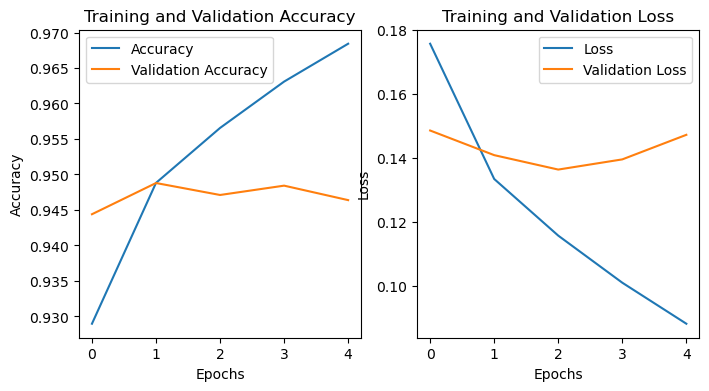

In [12]:
# Plotting the accuracy and loss over time 
  
# Training history 
history_dict = history.history 
  
# Seperating validation and training accuracy 
acc = history_dict['accuracy'] 
val_acc = history_dict['val_accuracy'] 
  
# Seperating validation and training loss 
loss = history_dict['loss'] 
val_loss = history_dict['val_loss'] 
  
# Plotting 
plt.figure(figsize=(8, 4)) 
plt.subplot(1, 2, 1) 
plt.plot(acc) 
plt.plot(val_acc) 
plt.title('Training and Validation Accuracy') 
plt.xlabel('Epochs') 
plt.ylabel('Accuracy') 
plt.legend(['Accuracy', 'Validation Accuracy']) 
  
plt.subplot(1, 2, 2) 
plt.plot(loss) 
plt.plot(val_loss) 
plt.title('Training and Validation Loss') 
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend(['Loss', 'Validation Loss']) 
  
plt.show()

12500/12500 ━━━━━━━━━━━━━━━━━━━━ 510s 41ms/step


<Figure size 800x600 with 0 Axes>

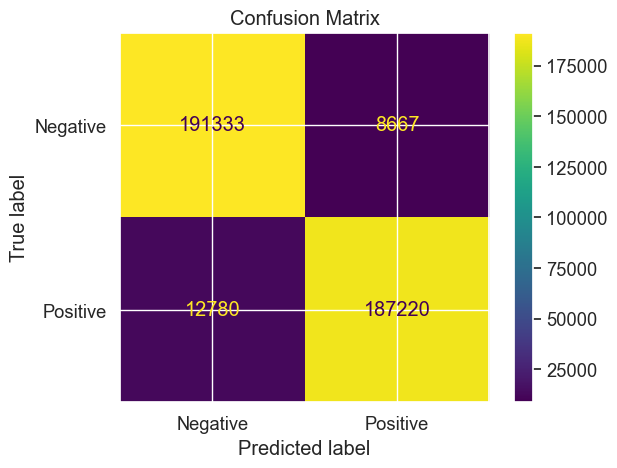

In [13]:
# Predicting labels for the test set
y_pred = model.predict(df_test["processed_comments"].values)
y_pred_classes = (y_pred > 0.5).astype(int)  # Converting probabilities to classes

# Generating confusion matrix
cm = confusion_matrix(df_test["label"], y_pred_classes)

# Displaying confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust font scale for better readability
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"]).plot()
plt.title("Confusion Matrix")
plt.show()

In [14]:
report = classification_report(df_test["label"], y_pred_classes)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95    200000
           1       0.96      0.94      0.95    200000

    accuracy                           0.95    400000
   macro avg       0.95      0.95      0.95    400000
weighted avg       0.95      0.95      0.95    400000

